### SA Heart Disease

This is a presentation of an analysis of heart disease study data to go over the statistical use of Logistic Regression model. The data comes as a subset of coronary-risk-factor study carried out in SA. The goal is to establish the intensity of heart disease risk factor for this region. Participants were in the group ages 15-64, and the respnse variable is the presence or absence of myocardic infarction (MI). At the time of the study the overall prevalence of MI was 5.1% for that region. 

Heart Disease dataset includes 160 cases and a sample of 302 controls. 

**Heart Disease Dataset**

A retrospective sample of males in a heart-disease high-risk region
of the Western Cape, South Africa. There are roughly two controls per
case of CHD. Many of the CHD positive men have undergone blood
pressure reduction treatment and other programs to reduce their risk
factors after their CHD event. In some cases the measurements were
made after these treatments. These data are taken from a larger
dataset, described in  Rousseauw et al, 1983, South African Medical
Journal. 

- sbp       systolic blood pressure
- tobacco		cumulative tobacco (kg)
- ldl       low densiity lipoprotein cholesterol
- adiposity
- famhist   family history of heart disease (Present, Absent)
- typea.    type-A behavior
- obesity
- alcohol.  current alcohol consumption
- age.      age at onset
- chd.      response, coronary heart disease



The data includes 160 cases and a sample of 302 controls, control means negative cases. The ratio of positive cases (160/462=0.35) which is the risk estimated of MI is 0.35 (35%). However this is not the actual prevalence for this region instead it is 0.05 (0.05%). When we fit the logistic regression to the data, then the estimated probability is too high, which is corrected with estimated intercept that goes through a transformation:
- b_hat = b_hat0 + log(actual_prevalence/(1-actual_prevalence) - (log(estimated_prevalence/1-estimated_prevalence) 

This is known as Case-Control-Sampling - very popular tool in epidemiology ~ even with rare diseaaes we take all cases we can find, and up to many times the number of control is sufficient 

Add the formulas - from the book, and add the exercises-solutions  (typed/scanned)

Approach
 - Data Load from the dataset repository 
 - Logistic Regression model by maximum Likelihood
 - Feature Selection to find the subset of the features that are sufficient for explaining their joint effect on the prevalence of the response coronary heart disease 
 - L1 Regularized Logistic Regression
 - Natural Cubic Splines Basis Expansion
 - Local Logistic Regression

In [ ]:
from google.colab import files 
files.upload()

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from scipy.stats import chi2
from matplotlib import pyplot as plt

In [ ]:
names_ = ['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'famhist', 'typea', 
          'obesity', 'alcohol', 'age', 'chd']
dataset_SAheart = pd.read_csv('heart_data.csv') #, names=names_)
dataset_SAheart.head(1), 

(   row.names  sbp  tobacco   ldl  adiposity  famhist  typea  obesity  alcohol  \
 0          1  160     12.0  5.73      23.11  Present     49     25.3     97.2   
 
    age  chd  
 0   52    1  ,)

In [ ]:
""" encode famhist with dummy variable, use get_dummies for subset - placeholder  """ 
dataset_SAheart['famhist'] = pd.get_dummies(dataset_SAheart['famhist'])['Present']
dataset_SAheart['famhist'].head(3)

0    1
1    0
2    1
Name: famhist, dtype: uint8

In [ ]:
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
target= 'chd'
dataset_SAheart[features + [target]].head(2), 

(   sbp  tobacco   ldl  famhist  obesity  alcohol  age  chd
 0  160    12.00  5.73        1    25.30    97.20   52    1
 1  144     0.01  4.41        0    28.87     2.06   63    1,)

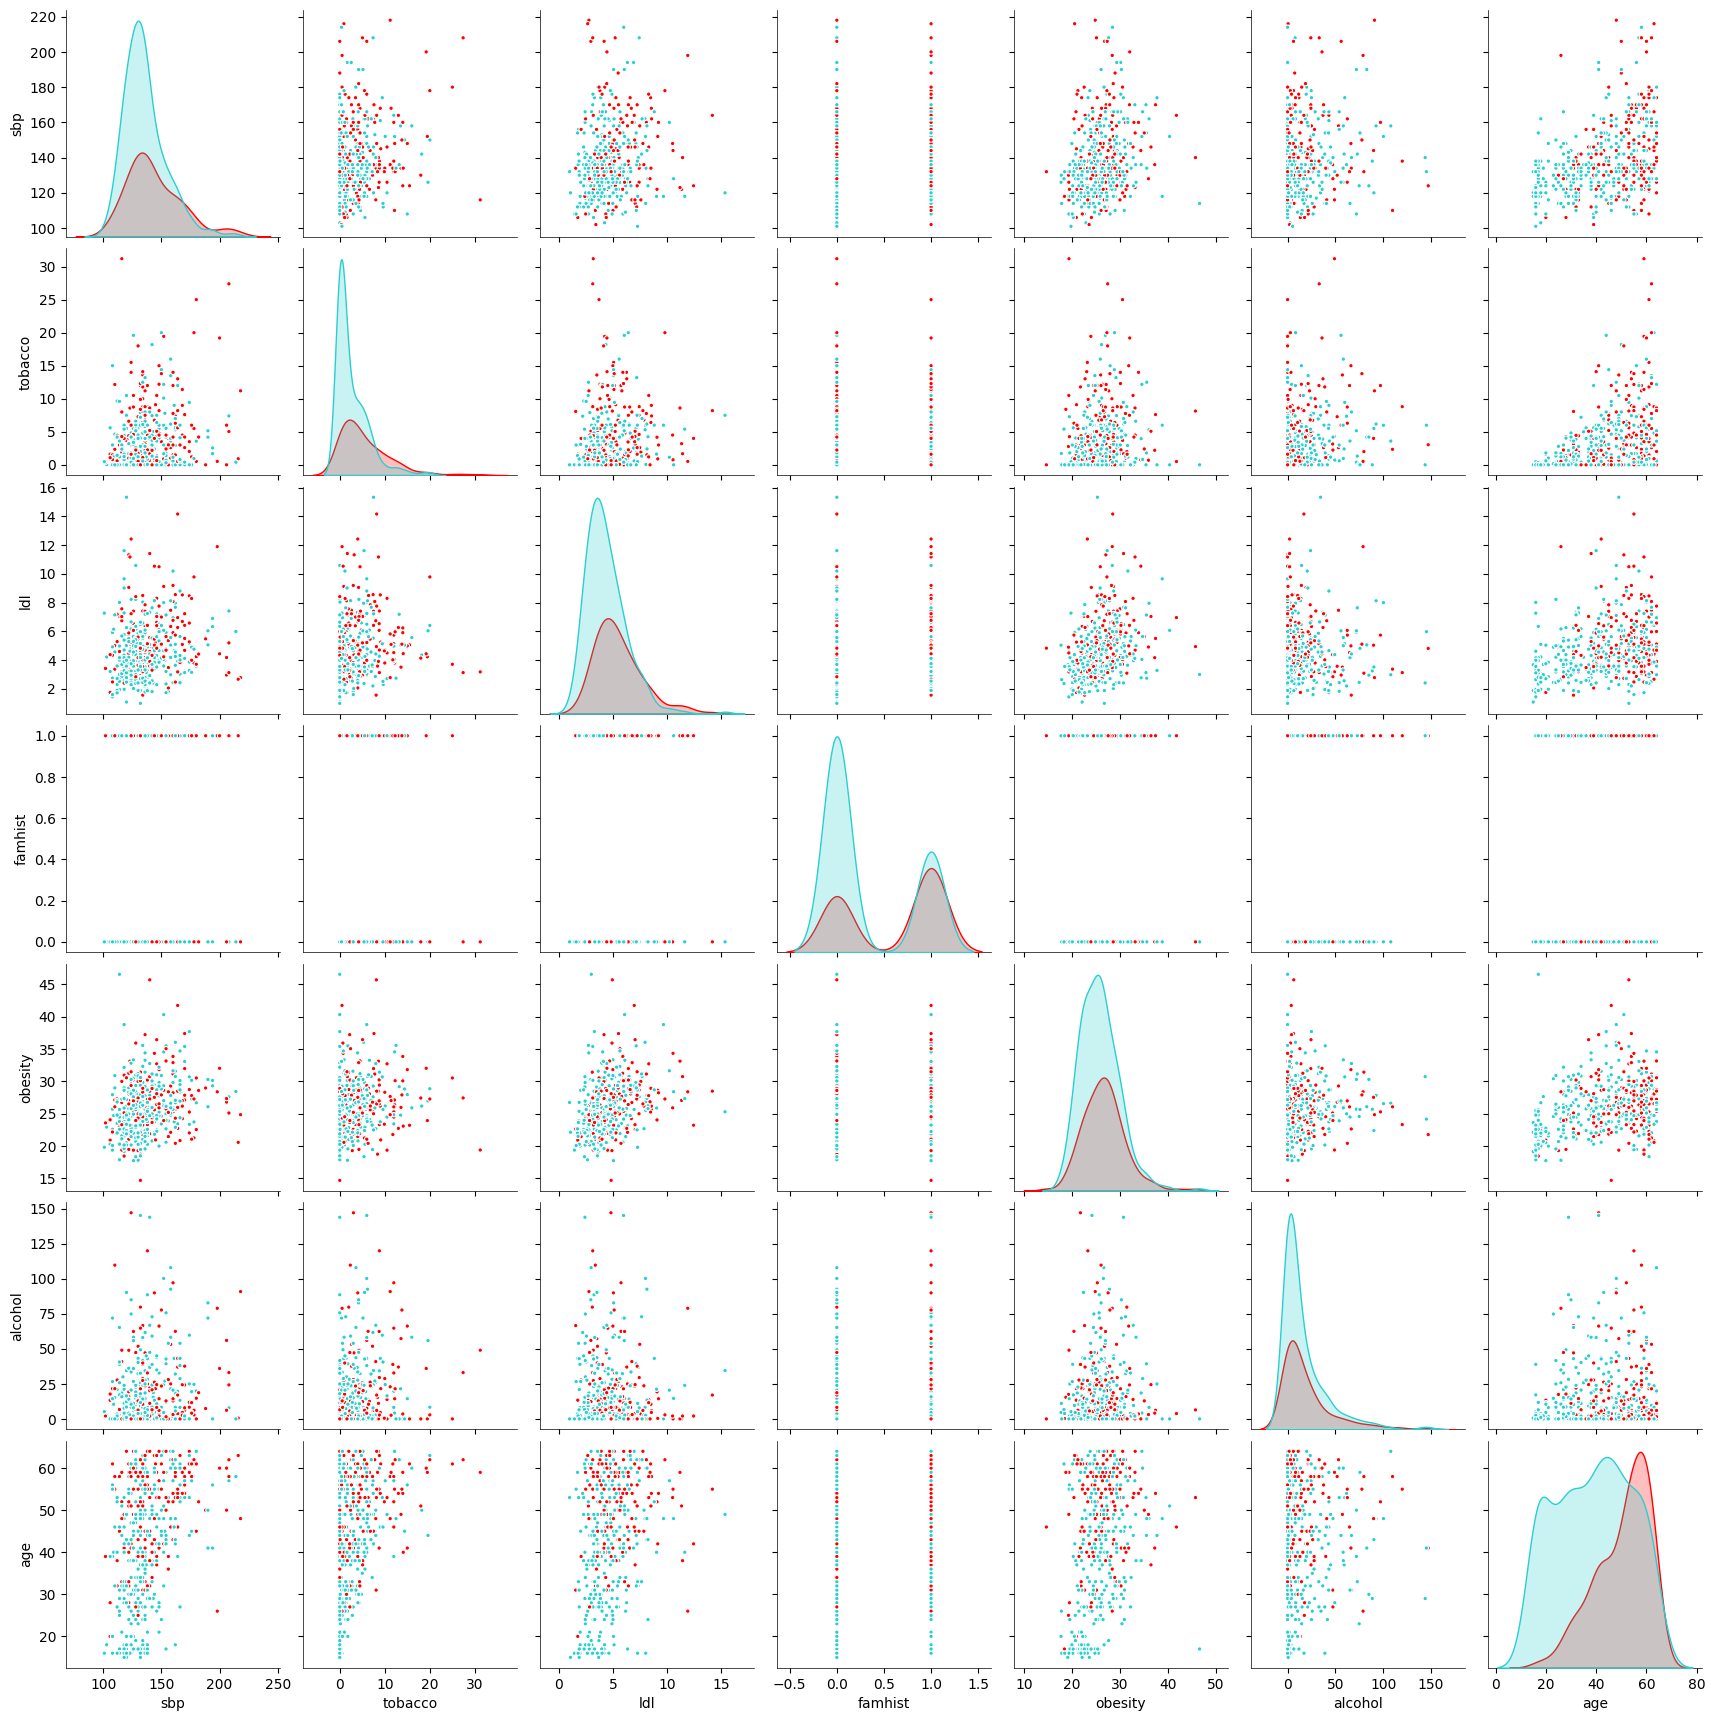

In [ ]:
""" scatterplot matrix of the south african heart disease data 
each plot shows a pair of risk factors, each pair shows the cases 
and controls, with cases in red, and a family history variable in binary """ 
sns.pairplot(
    dataset_SAheart, vars=features, kind="scatter", hue=target, 
    palette=['#29CFD0', '#FF0000'], plot_kws=dict(s=10, linewidth=0.8)
)._legend.remove()

In [ ]:
""" convert X, and y into numpy arrays """ 
X, y = dataset_SAheart[features].values,  dataset_SAheart[target].values 

In [ ]:
""" Linear Method for Classification """ 
X = np.insert(X, 0, values=1, axis=1)
N, p = X.shape

b = np.zeros(shape=(p))
delta = np.inf 
cnt =0
while delta > 0.000000001 and cnt< 6: 
  gradient = np.zeros(shape=(1, p))
  hessian = np.zeros(shape=(p, p)) 
  loss = 0 
  for i in range(N):
    b_xi = b @ X[i]
    ebx = np.exp(b_xi)
    p_xi = ebx/(1 + ebx)
    gradient += X[i] * (y[i,0] - p_xi)
    xi = np.reshape(X[i], (1, p))
    hessian += -(xi.T @ xi) * p_xi * (1 - p_xi)
    loss += y[i][0] *b_xi - np.log(1 + np.exp(b_xi))
  delta = np.squeeze(np.linalg.inv(hessian) @ gradient.T)
  b -= delta 
  cnt +=1
  delta = delta @ delta.T
  print(f'loss {loss} b {b}')

""" use the book for summary """ 
y_predict = np.zeros(shape=y.shape)
for i in range(N):
  e = np.exp(b @ X[i]) 
  ps = [1/(1 + e), e/(1 + e)]
  y_predict[i, 0] = np.argmax(ps)
np.sum(y == y_predict) 

loss -320.2339974186954 b [-2.89425926e+00  4.99067478e-03  6.80730379e-02  1.43630545e-01
  7.22416720e-01 -2.97134385e-02 -3.94429295e-04  2.66537887e-02]
loss -245.79726362664843 b [-3.89837325e+00  5.73041602e-03  7.81358795e-02  1.79154602e-01
  9.06119630e-01 -3.47966091e-02  3.62542828e-04  3.95176105e-02]
loss -241.70241294159888 b [-4.12089966e+00  5.76143693e-03  7.94835918e-02  1.84613477e-01
  9.38127701e-01 -3.45790601e-02  5.96619499e-04  4.24287280e-02]
loss -241.58716354419536 b [-4.12958772e+00  5.76067881e-03  7.95255787e-02  1.84779133e-01
  9.39184166e-01 -3.45435002e-02  6.06487630e-04  4.25410559e-02]
loss -241.5870161826394 b [-4.12959973e+00  5.76067669e-03  7.95256307e-02  1.84779334e-01
  9.39185489e-01 -3.45434338e-02  6.06501726e-04  4.25412099e-02]


337

In [ ]:
""" Use Logistic Regression with statsmodel API 
We review the results from the Logistic Regression fit to the heart disease data 
Table of coefficients interpreted with caustion 
Systolic blood pressure (sbp) is not significant
""" 
import statsmodels.api as stats 
logist_reg = stats.Logit(y, stats.add_constant(X)).fit(disp=False)
result = zip(['(Intercept)'] + features, 
             logist_reg.params, logist_reg.bse, logist_reg.tvalues)
print('           Coefficient   Std.Error   Z Score')
print('--------------------------------------------')
for term, coefficient, std_err, z_score in result:
  print(f'{term:>11} {coefficient:>10.2f} {std_err:>10.2f} {z_score:>10.2f}')

           Coefficient   Std.Error   Z Score
--------------------------------------------
(Intercept)      -4.13       0.96      -4.28
        sbp       0.01       0.01       1.02
    tobacco       0.08       0.03       3.03
        ldl       0.18       0.06       3.22
    famhist       0.94       0.22       4.18
    obesity      -0.03       0.03      -1.19
    alcohol       0.00       0.00       0.14
        age       0.04       0.01       4.18


In [ ]:
""" Feature Selection 
Find the subset of the variables sufficient for explaining the joint effect on
the prevalence of the chd. One way to proceed is to drop least significant and 
rifit the model. Continue this -repeat until no further variable can be dropped

Another approach is to refit each of the models with one variable removed, 
perform analysis of deviance to decide which variable to exclude. 
The residual deviance of a fitted model is minus its log likehood, and the 
deviance between two models is the difference of their individual residual
deviances in analogy to the squares 
"""
from sklearn.metrics import log_loss 
from sklearn.linear_model import LogisticRegression 
""" define the logistic model """ 
logistic_reg = LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10)
""" calculate total deviance of a model on a dataset """ 
def model_deviance(X, y, lr_model):
  return 2*log_loss(y, lr_model.predict_proba(X), normalize=False)
""" calculate total deviance of a model trained on features subset """ 
def model_subset_deviance(lr_model, selected_feature_ids):
  X_selected = X[:, sorted(list(selected_feature_ids))]
  lr_model.fit(X_selected, y)
  return model_deviance(X_selected, y, lr_model)
""" for all features store feature indices """ 
selected_feature_ids = set(range(len(features)))
current_deviance = model_subset_deviance(logistic_reg, selected_feature_ids)
while True:
  """ what would be the total deviance if we remove one feature """ 
  deviances = [(  model_subset_deviance(
                      logistic_reg, selected_feature_ids - set([idx])),
                  idx) for idx in selected_feature_ids] 
  """ find a feature to remove and minimize resulting total deviance """ 
  min_deviance, feature_to_remove_ids = min(deviances)
  """ the difference between the deviances of two models - first one,
  and the model with the feature removed - follows an approximate 
  chi-squared-distribution that we use for the stopping criteria """ 
  deviance_difference = min_deviance - current_deviance 
  p_value = 1 - chi2.cdf(deviance_difference, df=1) 
  if p_value < 0.05: break 
  selected_feature_ids -= set([feature_to_remove_ids])
  current_deviance = min_deviance 
  print(f'Remove: {features[feature_to_remove_ids]}')
selected_feature_ids = sorted(list(selected_feature_ids))
features_selected = [features[i] for i in selected_feature_ids]

""" Results from stepwise logistic regression fit to heart disease dataset """ 
logistic_reg = stats.Logit(y, 
                           stats.add_constant(X[:, selected_feature_ids])
).fit(disp=False) 

""" 
for feature tabacco interpret coefficient 0.08 and std error 0.026 (0.03) 
feature - tabacco is measured in total lifetime in kg, with a median of 1 kg 
for the controls (negative cases) and 4.1kg for cases (positive)
Therefore an increase of 1kg in lifetime tabacco usage accounts for an increase 
in the odds of coronary heart disease,  of exp(0.08)=1.084 or 8.4% 
Incorporating the Standard error we get a 95% confidence interval
of exp(0.081 +-2 * 0.026) = (1.029, 1.142)  
""" 
result = zip(['(Intercept)'] + features, 
             logist_reg.params, logist_reg.bse, logist_reg.tvalues)
print('           Coefficient   Std.Error   Z Score')
print('--------------------------------------------')
for term, coefficient, std_err, z_score in result:
  print(f'{term:>11} {coefficient:>10.2f} {std_err:>10.2f} {z_score:>10.2f}')

Remove: alcohol
Remove: sbp
Remove: obesity
           Coefficient   Std.Error   Z Score
--------------------------------------------
(Intercept)      -4.13       0.96      -4.28
        sbp       0.01       0.01       1.02
    tobacco       0.08       0.03       3.03
        ldl       0.18       0.06       3.22
    famhist       0.94       0.22       4.18
    obesity      -0.03       0.03      -1.19
    alcohol       0.00       0.00       0.14
        age       0.04       0.01       4.18


Text(0, 0.5, 'Coefficients |Beta(Lambda|')

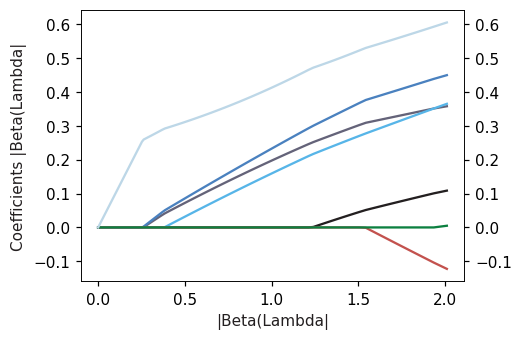

In [ ]:
""" L1 Regularized Logistic Regression """ 
from sklearn.preprocessing import StandardScaler 
alpha_ = np.linspace(1, 82, 100)
l1_logistic_reg = stats.Logit(
    y, stats.add_constant(StandardScaler().fit_transform(X)))
coefficients = np.vstack([
     l1_logistic_reg.fit_regularized(
         disp=False, alpha=a).params[1:] for a in alpha_]) 
coefficients_l1_norm = np.sum(np.abs(coefficients), axis=1) 
fig, ax = plt.subplots(figsize=(4.5, 3.2), dpi=110)
colors = ["#231F20","#646379",'#57B5E8','#4A81BF','#C3524E','#0C8040','#bdd7e7']
for i in range(7): 
  ax.plot(coefficients_l1_norm, coefficients[:, i], color=colors[i])
ax_cp = ax.twinx()
ax_cp.set_ylim(ax.get_ylim())
#plt.setp(ax_cp, yticks=coefficients[0], yticklabels=features)
for i in ax.get_yticklabels() + ax.get_xticklabels() + ax_cp.get_yticklabels():
  i.set_fontsize=8
ax.set_xlabel('|Beta(Lambda|', color=gray_, fontsize=10)
ax.set_ylabel('Coefficients |Beta(Lambda|', color=gray_, fontsize=10)

In [ ]:
""" Scikit-Learn does not have the thin-plate splines. Use RBF """ 
from scipy.spatial import ConvexHull 
from scipy.interpolate import Rbf 
from matplotlib import cm
""" remove one outlier beause it expands the conve hull """ 
dataset_SAheart = dataset_SAheart[~(
    (dataset_SAheart.age < 20) & (dataset_SAheart.age > 45))]
age_values = dataset_SAheart.age.values.astype(np.float)
obesity_values = dataset_SAheart.obesity.values.astype(np.float)
sbp_values = dataset_SAheart.sbp.values.astype(np.float)
""" convex hull """ 
hull_ = ConvexHull(np.vstack((age_values, obesity_values)).T)
""" check if a point is in convex hull or not """ 
def point_in_hull(point, hull, tolerance=1e-12): 
  return all(
     [ np.dot(eq[:-1], point) + eq[-1] <= tolerance for eq in hull_.equations] 
  )
""" Rbf  """
grid_size = 500 
age_grid, obesity_grid = np.meshgrid(
    np.linspace(min(age_values), max(age_values), grid_size), 
     np.linspace(min(obesity_values), max(obesity_values), grid_size),    
) 
sbp_mean = np.mean(sbp_values)
rbf_model = Rbf(
    age_values, obesity_values, sbp_values - sbp_mean, 
    smooth=30, function='multiquadric'
)
sbp_grid = rbf_model(age_grid, obesity_grid) +sbp_mean 

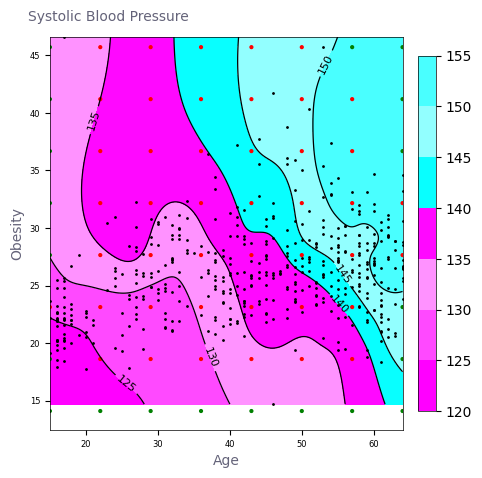

In [ ]:
""" plot the data """ 
levels = [120, 125, 130, 135, 140, 145, 150, 155]
colors = ['#FF00FF', '#FF49FF', '#FF92FF', '#FF08FF', 
          '#08FFFF', '#92FFFF', '#49FFFF', '#00FFFF']
fig, ax = plt.subplots(figsize=(5.1, 5.1), dpi=100)
cf = ax.contourf(age_grid, obesity_grid, sbp_grid, 
                 levels=levels, colors=colors)
cs = ax.contour(age_grid, obesity_grid, sbp_grid, 
                levels=levels, colors='black', linewidths=0.9)
ax.clabel(cs, inline=1, fontsize=8, fmt='%1.0f')
ax.scatter(age_values, obesity_values, s=1, color='black')
ax.set_aspect(1.6)
latice = np.transpose([np.tile(np.linspace(15, 64, 8), 8), 
                       np.repeat(np.linspace(14.1, 45.7, 8), 8)] )
colors = [('green', 'red')[point_in_hull(latice[i], hull_)] 
          for i in range(latice.shape[0])]
ax.scatter(latice[:, 0], latice[:, 1], s=4, color=colors)
for i in ax.get_yticklabels() + ax.get_xticklabels(): i.set_fontsize(6)
ax.set_xlabel('Age', color=gray__, fontsize=10)
ax.set_ylabel('Obesity', color=gray__, fontsize=10)
fig.colorbar(cf, ax=ax, fraction=0.045, pad=0.04)
ax.text(12, 48, 'Systolic Blood Pressure', color=gray__, fontsize=10)
plt.show()

In [ ]:
""" Local Logistic Regression 
The Local Logistic Regression uses tri-cube kernel with k-NN badwidth, widens 
the kernel and makes use of local linear assumption to smooth out the estimates
(on logist scale) """
from sklearn.utils import resample 
from scipy.spatial.distance import cdist 
class LocalRegression(BaseEstimator):
  def __init__(self, model, kernel_size):
    self.model, self.kernel_size = model, kernel_size 
  
  def fit(self, X, y):
    self.X, self.y = X, y
    return self
  
  def predict_proba(self, X):
    return self.__predict(X, self.model.predict_proba)
  
  def __predict(self, X, fnc):
    result = []
    for i in range(X.shape[0]): 
      self.model.fit(
          self.X, self.y, 
          sample_weight = self.__tri_cube_kernel(X[i:i +1, :])  
      )
      result.append(np.atleast_2d(fnc([X[i]])))
    return np.vstack(result)

  def predict(self, X):
    return self.__predict(X, self.model.predict)

  def __tri_cube_kernel(self, x0):
    points_count = self.kernel_size 
    if points_count <=1:
      points_count = int(self.X.shape[0] * points_count)
    distances = cdist(self.X, x0)
    kernel_points_indices= np.argpartition(
        distances, points_count, axis=0)[:points_count]
    max_distance = np.max(distances[kernel_points_indices]) 
    relative_distance = distances/max_distance 
    relative = (relative_distance <=1)*(1-relative_distance**3)**3
  
def bootstrap_local_logistic_reg(X, y, X_, k):
  result = np.zeros(shape=(100, X_.shape[0]))
  local_logistic_regression = LocalRegression(
      model=LogisticRegression(solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=True),
      kernel_size=k
  )
  for i in range(result.shape[0]):
    local_logistic_regression.fit(*resample(X, y))
    result[i] = local_logistic_regression.predict_proba(X_)[:, 1]
  return np.percentile(result, [16,50,84], axis=0)


In [ ]:
""" target values """ 
chd_values = dataset_SAheart.chd.values
sbp_values = dataset_SAheart[['sbp']].values.astype(np.float64)
""" bootstrap local linear regression for sbp """ 
sbp_space = np.linspace(
    np.min(sbp_values), np.max(sbp_values), 100).reshape(100, 1)
sbp_conf_interval = bootstrap_local_logistic_reg(
    sbp_values, chd_values, sbp_space, 300)

((462, 1), (462,), (100, 1))

In [ ]:
""" bootstrap local linear regression for obesity """ 
obesity_values = dataset_SAheart[['obesity']].values.astype(np.float64)
obesity_space = np.linspace(
    np.min(obesity_values), np.max(obesity_values), 100).reshape(100, 1)
obesity_conf_interval = bootstrap_local_logistic_reg(
    obesity_values, chd_values, obesity_space, 300)

Text(0, 0.5, 'Prevalence chd')

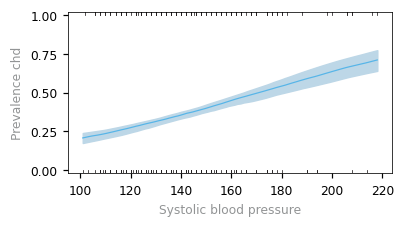

In [ ]:
fig, ax = plt.subplots(figsize=(3.8, 1.9), dpi=110)
ax.fill_between(sbp_space[:, 0], sbp_conf_interval[0], sbp_conf_interval[2], color=blue__)
ax.plot(sbp_space[:, 0], sbp_conf_interval[1], color=blue_, linewidth=0.8)

for i in range(sbp_values.shape[0]):
  y_from = (-0.02, 1)[y[i]]
  ax.plot([sbp_values[i, 0], sbp_values[i, 0]], 
          [y_from, y_from+0.02], color=gray_, linewidth=0.5)
for i in ax.get_yticklabels() + ax.get_xticklabels(): i.set_fontsize(8)
ax.set_ylim(-0.02, 1.02) 
ax.set_xlabel('Systolic blood pressure', color=gray___, fontsize=8)
ax.set_ylabel('Prevalence chd', color=gray___, fontsize=8)

Text(0, 0.5, 'Prevalence chd')

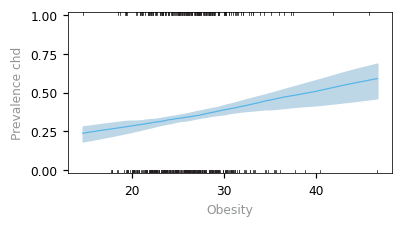

In [ ]:
fig1, ax1 = plt.subplots(figsize=(3.8, 1.9), dpi=110)
ax1.fill_between(obesity_space[:, 0], obesity_conf_interval[0], obesity_conf_interval[2], color=blue__)
ax1.plot(obesity_space[:, 0], obesity_conf_interval[1], color=blue_, linewidth=0.8)

for i in range(obesity_values.shape[0]):
  y_from = (-0.02, 1)[y[i]]
  ax1.plot([obesity_values[i, 0], obesity_values[i, 0]], [y_from, y_from+0.02], color=gray_, linewidth=0.5)
for i in ax1.get_yticklabels() + ax1.get_xticklabels(): i.set_fontsize(8)
ax1.set_ylim(-0.02, 1.02) 
ax1.set_xlabel('Obesity', color=gray___, fontsize=8)
ax1.set_ylabel('Prevalence chd', color=gray___, fontsize=8)

In [ ]:
def plot_local_regresion(ax, x_label, x_space, x_vales, x_conf_intervals):
  ax.fill_between(x_space[:, 0], x_conf_intervals[0], x_conf_intervals[2], color=blue__)
  ax.plot(x_space[:, 0], x_conf_intervals[1], color=blue_, linewidth=0.8)

  for i in range(x_vales.shape[0]):
    y_from = (-0.02, 1)[y[i]]
    ax.plot([x_vales[i, 0], x_vales[i, 0]], 
            [y_from, y_from+0.02], color=gray_, linewidth=0.5)
  for i in ax.get_yticklabels() + ax.get_xticklabels(): i.set_fontsize(8)
  ax.set_ylim(-0.02, 1.02) 
  ax.set_xlabel(x_label, color=gray___, fontsize=8)
  ax.set_ylabel('Prevalence chd', color=gray___, fontsize=8) 

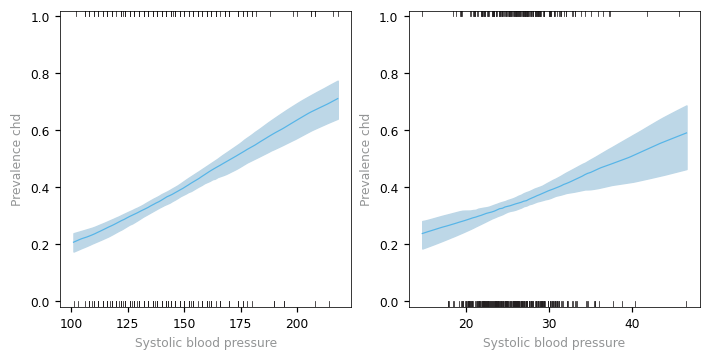

In [ ]:
fig, ax_ = plt.subplots(1, 2, figsize=(7.5, 3.5), dpi=110)
plot_local_regresion(ax_[0], 'Systolic blood pressure', 
                     sbp_space, sbp_values, sbp_conf_interval)

plot_local_regresion(ax_[1], 'Systolic blood pressure', 
                     obesity_space, obesity_values, obesity_conf_interval)

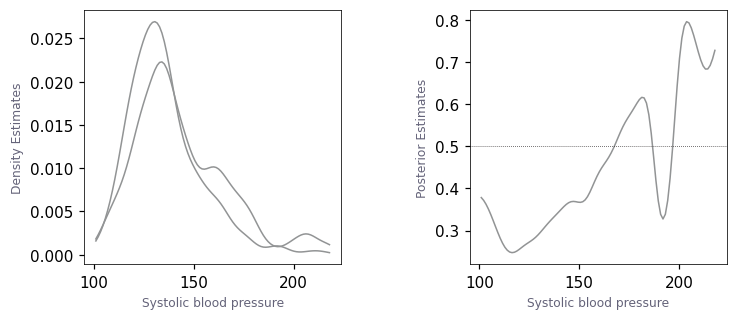

In [ ]:
""" Kernel Density Estimation 
Two separate estimates for Systolic blood pressure for group with chd 
versus no chd (coronary-heart-disease) group, using Gaussian kernel 
density estimation on each """ 
from sklearn.neighbors import KernelDensity
sbp_values_chd = dataset_SAheart[
    dataset_SAheart.chd ==1][['sbp']].values.astype(np.float64)
sbp_values_nochd = dataset_SAheart[
    dataset_SAheart.chd ==0][['sbp']].values.astype(np.float64)
prior_cases = sbp_values_chd.size/(
                                  sbp_values_chd.size + sbp_values_nochd.size)
prior_control = 1 - prior_cases
kde = KernelDensity(kernel='gaussian', bandwidth=5)
chd_density = np.exp(
    kde.fit(sbp_values_chd).score_samples(sbp_space))
nochd_density = np.exp(
    kde.fit(sbp_values_nochd).score_samples(sbp_space))
posterior_cases = \
  prior_cases*chd_density/(prior_cases*chd_density + prior_control*nochd_density)

fig, ax = plt.subplots(1, 2, figsize=(7.3, 3), dpi=110)
plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
ax[0].plot(sbp_space, chd_density, label='CHD', color=gray___, linewidth=1)
ax[0].plot(sbp_space, nochd_density, label='No CHD', color=gray___, linewidth=1)
ax[0].set_xlabel('Systolic blood pressure', color=gray__, fontsize=8)
ax[0].set_ylabel('Density Estimates', color=gray__, fontsize=8)

ax[1].plot(sbp_space, posterior_cases, color=gray___, linewidth=1)
ax[1].set_xlabel('Systolic blood pressure', color=gray__, fontsize=8)
ax[1].set_ylabel('Posterior Estimates', color=gray__, fontsize=8)
ax[1].axhline(y=0.5, c=gray_, linewidth=0.5, linestyle='dotted')

In [ ]:
""" Gaussian Mixture for Density Estimation and Classification 
Use combined variables with data, and fit a two component mixture in the form 
of Mixture model with scalars sigma1, and sigma2 not constraint to be equal. 
Fitting to be done with EM algorithm and the procedure should not use/have 
knowledge of CHD labels """ 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import norm

age_values = dataset_SAheart[['age']].astype(np.float64)
age_values_chd = dataset_SAheart[
    dataset_SAheart.chd ==1][['age']].values.astype(np.float64)
age_values_nochd = dataset_SAheart[
    dataset_SAheart.chd ==0][['age']].values.astype(np.float64)
age_spaced = np.linspace(np.min(age_values), np.max(age_values), 100)
gm_model= GaussianMixture(
    n_components=2, covariance_type='spherical', means_init=[[10], [10]]
).fit(age_values)
nochd_rv = norm(loc=gm_model.means_[0], scale=np.sqrt(gm_model.covariances_[0]))
chd_rv = norm(loc=gm_model.means_[1], scale=np.sqrt(gm_model.covariances_[1]))


Text(30, 45, 'Combined (CHD + NoCHD)')

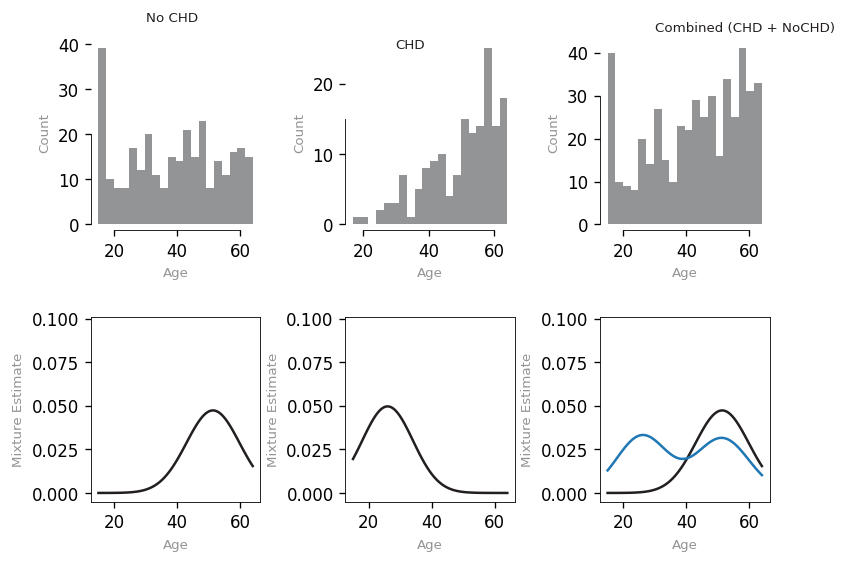

In [ ]:
""" Plot the results of Application of Mixtures for the SAHeart-Risk-Factor 
    Produce histograms of Age for NonCHD, and Age for CHD, separately and combined
    Density Estimates components for Gaussian Mixture 
    The Avg. Estimated Density should have a large standard deviation (show that)
    and it should approximate the uniform density 
"""
fig, ax = plt.subplots(2, 3, figsize=(7.3, 5), dpi=120)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
ax[0, 0].hist(age_values_nochd, bins=20, linewidth=0.3, color=gray___)
ax[0, 1].hist(age_values_chd, bins=20, linewidth=0.3, color=gray___)
ax[0, 2].hist(age_values, bins=20, linewidth=0.3, color=gray___)
ax[1, 0].plot(age_spaced, nochd_rv.pdf(age_spaced), color=gray_)
ax[1, 1].plot(age_spaced, chd_rv.pdf(age_spaced), color=gray_)
ax[1, 2].plot(age_spaced, nochd_rv.pdf(age_spaced), color=gray_)
ax[1, 2].plot(age_spaced, 
    gm_model.weights_[0]*nochd_rv.pdf(age_spaced) + 
    gm_model.weights_[0]*chd_rv.pdf(age_spaced))
offset = transforms.ScaledTranslation(0, -0.05, fig.dpi_scale_trans)

for i in range(3):
  ax[1, i].set_ylim(-0.005, 0.101) 
  ax[0, i].spines['right'].set_visible(False)
  ax[0, i].spines['top'].set_visible(False)
  ax[0, i].spines['bottom'].set_bounds(20, 60)
  ax[0, i].spines['left'].set_bounds(0, [20, 15, 30][i])

  ax[0, i].set_xlabel('Age', color=gray___, fontsize=8)
  ax[1, i].set_xlabel('Age', color=gray___, fontsize=8)
  ax[0, i].set_ylabel('Count', color=gray___, fontsize=8)
  ax[1, i].set_ylabel('Mixture Estimate', color=gray___, fontsize=8)

  for item in [ax[0, i].spines['bottom']] + \
               ax[0, i].get_xticklabels() + \
               ax[0, i].xaxis.get_ticklines(): 
               item.set_transform(item.get_transform() + offset)
  """
  for ax in [ax[0, i], ax[1, i]]: 
    for i in ax.get_yticklabels() + ax.get_xticklabels(): i.set_fontsize(8) 
    for i in ax.get_yticklabels(): i.set_rotation(90)      """
 
ax[0, 0].text(30, 45, 'No CHD', color=gray_, fontsize=8)
ax[0, 1].text(30, 25, 'CHD', color=gray_, fontsize=8)
ax[0, 2].text(30, 45, 'Combined (CHD + NoCHD)', color=gray_, fontsize=8)

In [ ]:
y_hat = gm_model.predict(age_values)
acc_score, conf_mx = accuracy_score(y, y_hat), confusion_matrix(y, y_hat)
print(f'          | Mixture model')
print(f'          | Sigma=0 Sigma=1')
print(f'---------------------------')
print(f'CHD NO    | {conf_mx[0,0]} {conf_mx[0,1]}')
print(f'CHD YES   | {conf_mx[1,0]} {conf_mx[1,1]}')
print(f'\nError rate: {1- acc_score:.2f}')

          | Mixture model
          | Sigma=0 Sigma=1
---------------------------
CHD NO    | 174 128
CHD YES   | 141 19

Error rate: 0.58


In [ ]:
""" Use the Natural Cubic Splines Basis Expansion 

N_1(X) = 1, N_2(X) = X, N_k+2(X) d_k(X) - d_k-1(X)
d_k(X) = (X -eps_k)^3 - (X -eps_K)^3 / (eps_k - eps_K)
""" 
from sklearn.preprocessing import FunctionTransformer

""" Use four natural spline bases for each term in the model, like 
X1-feature representing 'sbp', h1(X1) consists of four basis functions - 
three rather than two interior knots - chosen at uniform quantiles of 'sbp' 
and two boundary knots at the extremes of data, we exclude constant term 
from each of  the hj """ 
ncs_model = NaturalCubicSplineFeatures(target_dof=4)

add_intercept = FunctionTransformer(lambda X: stats.add_constant(X), validate=True)
data_prep_pipeline = Pipeline([
    ('scale_features', StandardScaler()), 
    ('expand_basis', ncs_model),
    ('scale_basis', StandardScaler()),
    ('add_intercept_column', add_intercept)])

""" at this point the model is like any other Linear Logistic model,and the 
algorithms for Logistic Regression apply """ 
logistic_reg = LogisticRegression(
    solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False)
expanded_logistic_reg = Pipeline([
    ('prepare', data_prep_pipeline), ('logistic', logistic_reg) ])

def subset_stats_aic(selected_feature_ids):
  X_selected = X[:, sorted(list(selected_feature_ids))]
  """ expand the basis for the selected features """ 
  X_selected_exp = data_prep_pipeline.fit_transform(X_selected, y)
  """ fit the regression model to the extended data and derive AIC """ 
  lr_stats = stats.Logit(
      y, X_selected_exp
  ).fit_regularized(method='l1', maxiter=1000, disp=False)
  return lr_stats.aic

""" start with all features, and carry out a backward stepwise deletion process 
dropping terms from the model while preserving the group structure of each term 
""" 
selected_feature_ids = set(range(len(features)))
current_aic = subset_stats_aic(selected_feature_ids)
current_deviance = model_subset_deviance(logistic_reg, selected_feature_ids)

In [ ]:
current_aic, current_deviance

(511.34324945546047, 502.2076454793695)

In [ ]:
while True:
  stat = [ (subset_stats_aic(selected_feature_ids - set([idx])), 
            model_subset_deviance(logistic_reg, selected_feature_ids - set([idx])),
            idx) 
          for idx in selected_feature_ids ]
  min_aic, dev, feature_to_remove_ids = min(stat)
  if min_aic > current_aic: break 
  selected_feature_ids -= set([feature_to_remove_ids])
  current_aic, current_deviance = min_aic, dev 
  print(f'Remove: {features[feature_to_remove_ids]}')

selected_feature_ids = sorted(list(selected_feature_ids))
stat_dict = {id: {aic, dev} for (aic, dev, id) in stat}
print('Feature list after removal', selected_feature_ids)
print('stat list', stat)
print('stat_dictionary list', stat_dict)

Remove: alcohol
Feature list after removal [0, 1, 2, 3, 4, 6]
stat list [(505.32763120265525, 505.7390967462726, 0), (506.475259385023, 515.4371806707051, 1), (510.4845434751752, 513.7658480109969, 2), (522.377384599801, 519.5184622146235, 3), (503.9279545821716, 522.2875439115193, 4), (521.7655811892022, 519.0173782856116, 6)]
stat_dictionary list {0: {505.32763120265525, 505.7390967462726}, 1: {506.475259385023, 515.4371806707051}, 2: {513.7658480109969, 510.4845434751752}, 3: {522.377384599801, 519.5184622146235}, 4: {522.2875439115193, 503.9279545821716}, 6: {521.7655811892022, 519.0173782856116}}


In [ ]:
""" refit the model to the selected features """ 
X_selected = X[:, selected_feature_ids]
updated_features = [features[id] for id in selected_feature_ids ]
print(f'Updated Feature list {updated_features}')
expanded_logistic_reg.fit(X_selected, y)
X_min = np.min(X_selected, axis=0)
X_max = np.max(X_selected, axis=0)
""" estimate covariance matrix """ 
H = data_prep_pipeline.transform(X_selected)
predicted_probs = expanded_logistic_reg.predict_proba(X_selected)
Weights = np.diagflat(np.product(predicted_probs, axis=1))
covariance = np.linalg.inv(H.T@Weights@H)
""" linear space for selected features and their basis expansions """ 
x_values = np.vstack([
    np.linspace(X_min[i], X_max[i], 100) for i in range(X_min.shape[0])]).T
x_values_expanded = data_prep_pipeline.transform(x_values)
""" drop rows/columns for intercepts """ 
x_values_expanded = x_values_expanded[:, 1:]

covariance = covariance[1:, 1:]
print(f'    Feature   Dt   Deviance   AIC       Dk        p-value')
print(f'----------------------------------------------------------')
logreg_t = []
for i, tuple_ in enumerate(stat):
  feature_aic, feature_dev, feature_id = tuple_ 
  logreg_t_ = feature_dev - current_deviance 
  logreg_t.append(logreg_t_)
  p_value = 1 - chi2.cdf(logreg_t_, df=ncs_model.dofs_[i])
  print(f'{features[feature_id]:>10}{ncs_model.dofs_[i]:>5}{feature_dev:>10.2f}' 
        f'{feature_aic:>10.2f}{logreg_t_:>10.2f}{p_value:>10.2f}')

Updated Feature list ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'age']
    Feature   Dt   Deviance   AIC       Dk        p-value
----------------------------------------------------------
       sbp    4    505.74    505.33      3.52      0.48
   tobacco    4    515.44    506.48     13.22      0.01
       ldl    4    513.77    510.48     11.55      0.02
   famhist    1    519.52    522.38     17.30      0.00
   obesity    4    522.29    503.93     20.07      0.00
       age    4    519.02    521.77     16.80      0.00


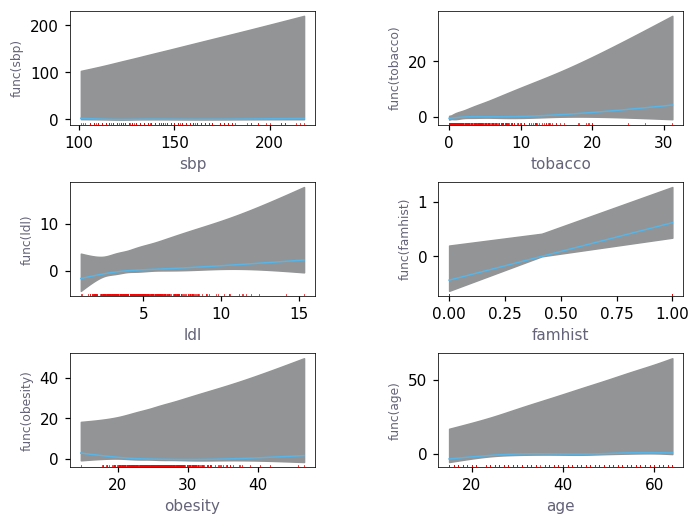

In [ ]:
def plot_feature_natural_spline(ax, feature_idx, feature_name):
  b_start, b_end = ncs_model.positions_[feature_idx]
  features_expanded = x_values_expanded[:, b_start: b_end +1]
  features_coefficient = logistic_reg.coef_[:, b_start +1: b_end +2].T
  features_covariance = covariance[b_start: b_end +1, b_start: b_end +1]
  feature_err = 2*np.sqrt(np.diag(features_expanded@features_covariance@features_expanded.T))
  feature_x_values = x_values[:, feature_idx]
  feature_y_values = np.squeeze(features_expanded@features_coefficient)
  ax.fill_between(
      feature_x_values, 
      feature_y_values - feature_err, feature_x_values + feature_err, 
      color=gray___)
  ax.plot(feature_x_values, feature_y_values, color=blue_, linewidth=1)
  y_from, y_to = ax.get_ylim()
  for i in range(X_selected.shape[0]):
    x = X_selected[i, feature_idx] 
    y_to_ = y_from + (y_to - y_from)*0.02
    ax.plot([x, x], [y_from, y_to_], color='red', linewidth=0.5)
  ax.set_ylim(y_from, y_to)
  ax.set_xlabel(f'{feature_name}', color=gray__, fontsize=10)
  ax.set_ylabel(f'func({feature_name})', color=gray__, fontsize=8)

""" We plotted the fitted spline functions for each one of the features
in the final model selected by the stepwise regression. Functions displayed are

f_j_hat(Xj) - H,(Xj)TTheta_j_hat for each variable Xj
Cov(Theta_hat) = Sigma (Sigma = (XT @W@X)^-1)
W is the diagonal weight matrix from the logistic regression 
... add the notation in text area .... 
Included are the standard errors, and the location of each of the 
sample values (represented in red) for the feature name-variable  

"""
fig, ax = plt.subplots(3, 2, figsize=(7.2, 5), dpi=110)
plt.subplots_adjust(bottom=0.05, wspace=0.5, hspace=0.5)
plot_feature_natural_spline(ax[0, 0], 0, 'sbp')
plot_feature_natural_spline(ax[0, 1], 1, 'tobacco')
plot_feature_natural_spline(ax[1, 0], 2, 'ldl')
plot_feature_natural_spline(ax[1, 1], 3, 'famhist')
plot_feature_natural_spline(ax[2, 0], 4, 'obesity')
plot_feature_natural_spline(ax[2, 1], 5, 'age')